CLOSED PERF

In [1]:
import pandas as pd
import numpy as np

# Load datasets
tass12 = pd.read_csv('tass12.csv')
car36 = pd.read_csv('car36.csv')

# Create the bridge dataset
bridge = tass12[['id', 'companyid']].drop_duplicates()
bridge.to_csv('bridge.csv', index=False)

# Create the closed_set dataset
closed_set = tass12[tass12['fund_closedxcrisis'] == 1][['mydate', 'companyid', 'id']]
closed_set.to_csv('closed_set.csv', index=False)

# Process car36 dataset
car36_filtered = car36[car36['mydate'] == 572][['id', 'avgCAR36', 'stdv_ex_move']]
car36_filtered = car36_filtered.rename(columns={'avgCAR36': 'avgCAR'})
car36_filtered = car36_filtered.sort_values(by='id')

# Merge with bridge
car36_merged = car36_filtered.merge(bridge, on='id', how='inner')

# Calculate closed_IR
car36_merged['closed_IR'] = car36_merged['avgCAR'] / car36_merged['stdv_ex_move']
car36_merged = car36_merged.drop(columns=['avgCAR', 'stdv_ex_move'])

# Calculate min_perf
car36_merged['min_perf'] = car36_merged.groupby('companyid')['closed_IR'].transform('min')

# Keep rows with min_perf
car36_merged = car36_merged[car36_merged['closed_IR'] == car36_merged['min_perf']]
car36_merged = car36_merged.drop_duplicates(subset=['companyid'])

# Create closed_IR quartiles
car36_merged['closed_IR_q1'] = (car36_merged['closed_IR'] <= car36_merged['closed_IR'].quantile(0.25)).astype(int)
car36_merged['closed_IR_q2'] = ((car36_merged['closed_IR'] > car36_merged['closed_IR'].quantile(0.25)) & (car36_merged['closed_IR'] <= car36_merged['closed_IR'].quantile(0.50))).astype(int)
car36_merged['closed_IR_q3'] = ((car36_merged['closed_IR'] > car36_merged['closed_IR'].quantile(0.50)) & (car36_merged['closed_IR'] <= car36_merged['closed_IR'].quantile(0.75))).astype(int)
car36_merged['closed_IR_q4'] = (car36_merged['closed_IR'] > car36_merged['closed_IR'].quantile(0.75)).astype(int)

car36_merged = car36_merged.drop(columns=['closed_IR'])

# Save the final closed_perf dataset
car36_merged = car36_merged.sort_values(by='companyid')
car36_merged.to_csv('closed_perf.csv', index=False)


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
car36 = pd.read_csv('car36.csv')
bridge = pd.read_csv('bridge.csv')
tass12 = pd.read_csv('tass12.csv')
closed_perf = pd.read_csv('closed_perf.csv')

# Process car36 data
car36 = car36[car36['mydate'] == 572][['id', 'avgCAR36', 'stdv_ex_move']]
car36 = car36.rename(columns={'avgCAR36': 'avgCAR'})
car36 = car36.merge(bridge, on='id', how='inner')

# Calculate minCAR and risk_closed
car36['minCAR'] = car36.groupby('companyid')['avgCAR'].transform('min')
car36 = car36[car36['avgCAR'] == car36['minCAR']].drop_duplicates(subset=['companyid'])
car36 = car36[['companyid', 'minCAR', 'stdv_ex_move']].rename(columns={'stdv_ex_move': 'risk_closed'})
car36['stdv_ex_move'] = car36['risk_closed']
car36['risk_closed'].fillna(car36['risk_closed'].median(), inplace=True)

car36.to_csv('minCAR.csv', index=False)

# Merge tass12 with minCAR
df = tass12.merge(car36, on='companyid', how='left')

# Merge with car36 data for avgCAR
car36_data = pd.read_csv('car36.csv')[['id', 'mydate', 'avgCAR36']]
df = df.merge(car36_data, on=['id', 'mydate'], how='left')
df = df.rename(columns={'avgCAR36': 'avgCAR'})

# Merge with closed_perf
df = df.merge(closed_perf, on='companyid', how='left', indicator=True)
df['closed_IR_missing'] = np.where(df['_merge'] != 'both', 1, 0)
df.loc[df['_merge'] != 'both', ['closed_IR_q1', 'closed_IR_q2', 'closed_IR_q3', 'closed_IR_q4']] = 0
# df.drop(columns=['_merge'], inplace=True)



/var/folders/jy/cfb14z9n637_y0c4jp4g2j1h0000gn/T/ipykernel_29745/2394645089.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car36['risk_closed'].fillna(car36['risk_closed'].median(), inplace=True)


In [3]:
print(df)

       companyid  mydate  excess_ret       ret  post        aum_x  firm_scope  \
0              1     408   23.463664 -0.097866   0.0  43924403.50           1   
1              1     409   23.571313  0.025886   0.0  45308613.90           1   
2              1     410   23.437843 -0.022044   0.0  44129826.57           1   
3              1     411   23.595777  0.085609   0.0  48707631.28           1   
4              1     412   23.523790  0.070713   0.0  52488920.23           1   
...          ...     ...         ...       ...   ...          ...         ...   
49120        199     515 -147.689333 -0.043578   0.0  28675540.32           1   
49121        199     516 -147.672489  0.051229   0.0  30427710.12           1   
49122        199     517 -147.682218  0.053733   0.0  32265542.50           1   
49123        199     518 -147.839420 -0.079913   0.0  29532279.99           1   
49124        199     519 -147.716216  0.105434   0.0  33138440.55           1   

       TREATED_x  firm_age 

In [4]:
for i in df.columns:
    print(i)

companyid
mydate
excess_ret
ret
post
aum_x
firm_scope
TREATED_x
firm_age
year_dum_1994
year_dum_1995
year_dum_1996
year_dum_1997
year_dum_1998
year_dum_1999
year_dum_2000
year_dum_2001
year_dum_2002
year_dum_2003
year_dum_2004
year_dum_2005
year_dum_2006
year_dum_2007
year_dum_2008
year_dum_2009
year_dum_2010
year_dum_2011
sz_q_0
sz_q_1
sz_q_2
sz_q_3
sz_q_4
sz_q_5
sz_q_6
sz_q_7
sz_q_8
sz_q_9
log_firmscope
log_firmage
firmage_q_0_x
firmage_q_1_x
firmage_q_2_x
firmage_q_3_x
firmage_q_4_x
firmage_q_5_x
firmage_q_6_x
firmage_q_7_x
firmage_q_8_x
firmage_q_9_x
stdv_firm
firm_ir
TREATED_y
missing_aum
int1c
ever_treated
first30
second30
id_x
div_corr
fund_closedxcrisis
firmscope
intheset
scope_q1
scope_q2
scope_q3
scope_q4
aum_y
log_age
ir
firmsz_q_0
firmsz_q_1
firmsz_q_2
firmsz_q_3
firmsz_q_4
firmsz_q_5
firmsz_q_6
firmsz_q_7
firmsz_q_8
firmsz_q_9
firmage_q_0_y
firmage_q_1_y
firmage_q_2_y
firmage_q_3_y
firmage_q_4_y
firmage_q_5_y
firmage_q_6_y
firmage_q_7_y
firmage_q_8_y
firmage_q_9_y
age_q_0


In [6]:
df['id'] = df['id_y']
df['aum'] = df['aum_x']
# df['avgCAR'] = df['avgCAR_x']
# df['stdv_ex_move'] = df['stdv_ex_move_x']
df.to_csv('temp_df.csv')
# Create treatment variables
df['treated'] = 0
df['max_treated'] = df.groupby('id')['TREATED'].transform('max')
df['treated'] = np.where((df['max_treated'] == 1) & (df['mydate'] == 572), 1, 0)
df = df[df['mydate'] <= 572]

df['aum'].fillna(df['aum'].median(), inplace=True)
df['log_aum'] = np.log(df['aum'] + 1)

# Time series variables
df = df.sort_values(by=['id', 'mydate'])
df['LavgCAR'] = df.groupby('id')['avgCAR'].shift(1)
df['Llog_aum'] = df.groupby('id')['log_aum'].shift(1)
df['Lmissing_aum'] = df.groupby('id')['missing_aum'].shift(1)
df['Llog_firmscope'] = df.groupby('id')['log_firmscope'].shift(1)
df['Llog_firmage'] = df.groupby('id')['log_firmage'].shift(1)
df['LminCAR'] = df.groupby('id')['minCAR'].shift(1)

# Create lagged Lfirmsz_q{i} variables
for i in range(1, 10):
    df[f'Lfirmsz_q{i}'] = df.groupby('id')[f'firmsz_q_{i}'].shift(1)

# Create quartile variables
def create_quartiles(df, var, new_var):
    quartiles = df[var].quantile([0.25, 0.5, 0.75])
    df[f'{new_var}_q1'] = np.where(df[var] <= quartiles[0.25], 1, 0)
    df[f'{new_var}_q2'] = np.where((df[var] > quartiles[0.25]) & (df[var] <= quartiles[0.5]), 1, 0)
    df[f'{new_var}_q3'] = np.where((df[var] > quartiles[0.5]) & (df[var] <= quartiles[0.75]), 1, 0)
    df[f'{new_var}_q4'] = np.where(df[var] > quartiles[0.75], 1, 0)
    return df

df = create_quartiles(df, 'log_age', 'age')
df = create_quartiles(df, 'Llog_firmscope', 'scope')
df = create_quartiles(df, 'LminCAR', 'minCAR')
df = create_quartiles(df, 'Llog_firmage', 'f_age')

# Create interaction and squared terms
df['age_sq'] = df['log_age'] ** 2
df['scope_sq'] = df['Llog_firmscope'] ** 2
df['fage_sq'] = df['Llog_firmage'] ** 2
df['minCAR_sq'] = df['LminCAR'] ** 2

df['psint1'] = df['log_age'] * df['LminCAR']
df['psint2'] = df['Llog_firmscope'] * df['LminCAR']
df['psint3'] = df['Llog_firmage'] * df['LminCAR']
df['psint4'] = df['log_age'] * df['Llog_firmscope']
df['psint5'] = df['log_age'] * df['Llog_firmage']
df['psint6'] = df['Llog_firmscope'] * df['Llog_firmage']

# Drop funds that closed
df = df[df['fund_closedxcrisis'] != 1]

# Drop funds that did not exist at the crisis start
df['min_mydate'] = df.groupby('id')['mydate'].transform('min')
df = df[df['min_mydate'] <= 561]

# Filter data for mydate == 572
df = df[df['mydate'] == 572]
# Drop funds with stdv_ex_move is missing and firmscope > 50
df = df[df['stdv_ex_move'].notna()]
df = df[df['firmscope'] <= 50]

# Probit model (I took out Lmissing_aum because it was 0 everywhere
exog_vars = ['LavgCAR', 'log_age', 'Llog_aum', 'Llog_firmscope', 'Llog_firmage', 'LminCAR', 'minCAR_sq', 'risk_closed'] + [f'Lfirmsz_q{i}' for i in range(1, 10)]
print(df[exog_vars].corr())

# Ensure all exog variables are numeric and there are no NaNs
df[exog_vars] = df[exog_vars].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=exog_vars)

# 4. Recreate exog
# 5. Fit the model
# Convert boolean columns to integers (0 or 1)
for col in exog_vars:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)
# Ensure treated column is numeric
df['treated'] = pd.to_numeric(df['treated'], errors='coerce')

# Check if exog is numeric
exog = sm.add_constant(df[exog_vars])

model = sm.Probit(df['treated'], exog).fit()
df['pscore'] = model.predict(exog)

# Save intermediate dataset
df.to_csv('just_after_probit.csv', index=False)


                 LavgCAR   log_age  Llog_aum  Llog_firmscope  Llog_firmage  \
LavgCAR         1.000000 -0.066304 -0.031749        0.139062     -0.124425   
log_age        -0.066304  1.000000  0.170912       -0.108807      0.483510   
Llog_aum       -0.031749  0.170912  1.000000        0.062819      0.252199   
Llog_firmscope  0.139062 -0.108807  0.062819        1.000000      0.202450   
Llog_firmage   -0.124425  0.483510  0.252199        0.202450      1.000000   
LminCAR         0.425557  0.023357 -0.159144       -0.451797     -0.255153   
minCAR_sq       0.362704 -0.031614 -0.123188       -0.420805     -0.344600   
risk_closed     0.002407  0.303790 -0.002084       -0.205029      0.268830   
Lfirmsz_q1     -0.064180 -0.147266 -0.257057       -0.322883     -0.223390   
Lfirmsz_q2      0.024573 -0.066312 -0.163853       -0.070087     -0.093291   
Lfirmsz_q3      0.023867 -0.008239 -0.120452       -0.124903     -0.061678   
Lfirmsz_q4      0.029564  0.054889  0.016690       -0.126746    

/var/folders/jy/cfb14z9n637_y0c4jp4g2j1h0000gn/T/ipykernel_29745/1601116419.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['aum'].fillna(df['aum'].median(), inplace=True)
/Users/hendrik/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/hendrik/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_mod

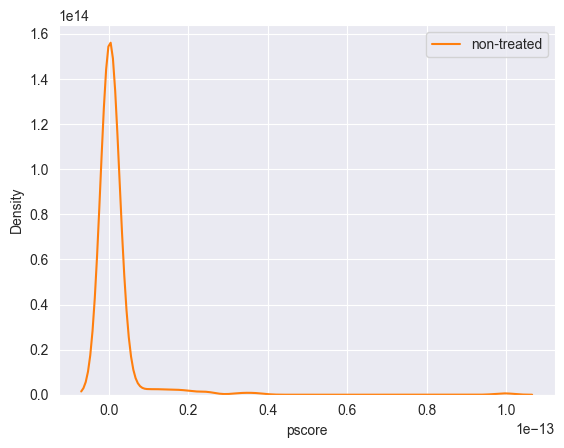

/var/folders/jy/cfb14z9n637_y0c4jp4g2j1h0000gn/T/ipykernel_29745/1629371331.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


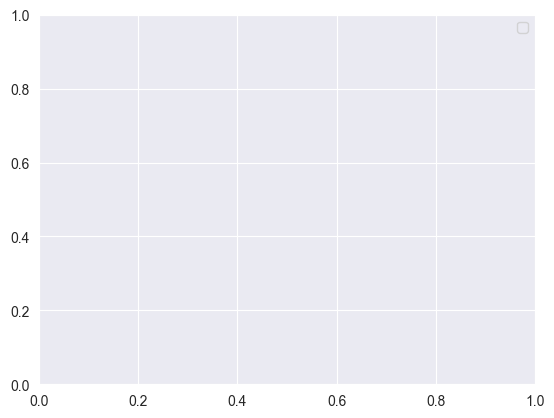

In [7]:
df = pd.read_csv('just_after_probit.csv')
# Filter out funds with missing pscore
df = df[df['pscore'].notna()]

# Calculate upper and lower bounds for common support
upper_bound99 = df[df['treated'] == 1]['pscore'].quantile(0.99)
upper_bound90 = df[df['treated'] == 1]['pscore'].quantile(0.90)
lower_bound = df[df['treated'] == 0]['pscore'].quantile(0.01)

df['xtreme'] = np.where((df['pscore'] > upper_bound99) | (df['pscore'] < lower_bound), 1, 0)

# Plot kernel density estimation (KDE) of pscore
sns.kdeplot(df.loc[(df['treated'] == 1) & (df['xtreme'] == 0), 'pscore'], label='treated')
sns.kdeplot(df.loc[(df['treated'] == 0) & (df['xtreme'] == 0), 'pscore'], label='non-treated')
plt.legend()
plt.show()

# Trim top and bottom 1%
df = df[df['xtreme'] == 0]
df = df.drop(columns=['xtreme'])

# Matching process
df = df.sort_values(by=['treated', 'pscore'], ascending=[False, True])
df['counter'] = df.groupby('treated').cumcount() + 1
df['matched'] = 0
df['matched_id'] = 0
df['nearest_neighbor'] = np.nan
df['ptreat'] = 0
df['id_to_match'] = 0
df['dif'] = 9999999

treated_df = df[df['treated'] == 1]
control_df = df[df['treated'] == 0]

for t in treated_df['counter'].unique():
    ptreat = treated_df[treated_df['counter'] == t]['pscore'].values[0]
    df['ptreat'] = ptreat
    df['dif'] = np.abs(df['ptreat'] - df['pscore'])
    mindif = df[(df['matched_id'] == 0) & (df['treated'] == 0)]['dif'].min()
    df['matched'] = np.where((df['dif'] == mindif) & (df['treated'] == 0) & (df['matched_id'] == 0), 1, df['matched'])
    df['maxmatched'] = df.groupby('id')['matched'].transform('max')
    df['matched_id'] = np.where(df['maxmatched'] == 1,                       1, df['matched_id'])
    df.loc[df['counter'] == t, 'id_to_match'] = df['id']
    treated_id = df[df['counter'] == t]['id'].values[0]
    df['nearest_neighbor'] = np.where((df['dif'] == mindif) & (df['treated'] == 0) & (df['matched_id'] == 1), treated_id, df['nearest_neighbor'])
    df['id_to_match'] = 0
    df['ptreat'] = 0
    df['dif'] = 9999999

df['control'] = np.where(df['matched'] == 1, 1, 0)
df = df[(df['treated'] == 1) | (df['control'] == 1)]
df = df.drop(columns=['counter', 'matched_id', 'ptreat', 'dif'])

df.to_csv('match.csv', index=False)

# KDE plot after matching
sns.kdeplot(df.loc[df['treated'] == 1, 'pscore'], label='treated')
sns.kdeplot(df.loc[df['control'] == 1, 'pscore'], label='control', linestyle='--')
plt.legend()
plt.show()

# Merge untreated observations with tass12 for control group
control_group = df[df['treated'] == 0].drop_duplicates(subset=['nearest_neighbor'])
control_group = control_group[['id']]
control_group = control_group.merge(tass12, on='id', how='left')

control_group.to_csv('match3.csv', index=False)

# Merge treated observations with tass12
treated_group = df[df['treated'] == 1][['id']]
treated_group = treated_group.merge(tass12, on='id', how='left')

# Append control group to treated group
matched_set = pd.concat([treated_group, control_group])

matched_set.to_csv('matched_set.csv', index=False)

In [8]:

# Table 4 Regressions
import statsmodels.formula.api as smf

# Rename columns to their expected names
rename_dict = {
    'TREATED_x': 'TREATED',
    'aum_x': 'aum',
    'firmage_q_0_x': 'firmage_q0',
    'firmage_q_1_x': 'firmage_q1',
    'firmage_q_2_x': 'firmage_q2',
    'firmage_q_3_x': 'firmage_q3',
    'firmage_q_4_x': 'firmage_q4',
    'firmage_q_5_x': 'firmage_q5',
    'firmage_q_6_x': 'firmage_q6',
    'firmage_q_7_x': 'firmage_q7',
    'firmage_q_8_x': 'firmage_q8',
    'firmage_q_9_x': 'firmage_q9',
    'firmsz_q_0.0': 'firmsz_q0',
    'firmsz_q_1.0': 'firmsz_q1',
    'firmsz_q_2.0': 'firmsz_q2',
    'firmsz_q_3.0': 'firmsz_q3',
    'firmsz_q_4.0': 'firmsz_q4',
    'firmsz_q_5.0': 'firmsz_q5',
    'firmsz_q_6.0': 'firmsz_q6',
    'firmsz_q_7.0': 'firmsz_q7',
    'firmsz_q_8.0': 'firmsz_q8',
    'firmsz_q_9.0': 'firmsz_q9',
}
matched_set.rename(columns=rename_dict, inplace=True)

# Ensure 'intheset' is boolean and 'mydate' is integer
print(matched_set['intheset'].dtype)
matched_set.dropna(subset=['intheset'], inplace=True)

matched_set['intheset'] = matched_set['intheset'].astype(int)
matched_set['mydate'] = matched_set['mydate'].astype(int)

# Filter data
filtered_data = matched_set[(matched_set['intheset'] == 1) & (matched_set['mydate'] <= 617) & (matched_set['firmscope'] < 50)]
# 1. Drop unnecessary dummy variables 
# Assuming you have dummy variables like sz_q0, sz_q1, ..., sz_q9, keep only sz_q1 to sz_q9

# 2. Handling Missing Values
# Impute or drop missing values in the relevant columns
filtered_data.dropna(subset=['ir', 'TREATED'] + [col for col in filtered_data.columns if col.startswith(('sz_q', 'scope_q', 'age_q', 'firmsz_q', 'firmage_q', 'year_dum_'))], inplace=True)

# 3. Filtering for clustering
# Ensure groups have at least two observations
id_counts = filtered_data['id'].value_counts()
filtered_data = filtered_data[filtered_data['id'].isin(id_counts[id_counts > 1].index)]

# Double-check and convert 'id' to numeric if needed
filtered_data['id'] = pd.to_numeric(filtered_data['id']) 
for i in filtered_data.columns:
    print(i)
    
# 4. Reset the index after filtering
filtered_data = filtered_data.reset_index(drop=True)
filtered_data.to_csv('filtered_data.csv')
# Basic IR Results
model_ir = smf.ols('ir ~ TREATED + ' +
                   ' + '.join([f'sz_q_{i}' for i in range(1, 10)]) + ' + ' +
                   ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                   # ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                   # ' + '.join([f'firmsz_q{i}' for i in range(1, 11)]) + ' + ' +
                   # ' + '.join([f'firmage_q{i}' for i in range(1, 11)]) + ' + ' +
                   ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                   data=filtered_data).fit(cov_type='cluster', cov_kwds={'groups': filtered_data['id']})

print(model_ir.summary())

# Save model results
with open('model_ir_results.txt', 'w') as f:
    f.write(model_ir.summary().as_text())

# Additional regressions as needed
model_absorb = smf.ols('ir ~ TREATED + ' +
                       ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                       ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                       ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                       ' + '.join([f'firmsz_q{i}' for i in range(1, 11)]) + ' + ' +
                       ' + '.join([f'firmage_q{i}' for i in range(1, 11)]) + ' + ' +
                       ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                       data=filtered_data).fit(cov_type='cluster', cov_kwds={'groups': filtered_data['id']})

print(model_absorb.summary())

with open('model_absorb_results.txt', 'w') as f:
    f.write(model_absorb.summary().as_text())

# Additional analyses and summary statistics
filtered_data['median_rel_int'] = np.where(filtered_data['int1c'] >= filtered_data['int1c'].median(), 1, 0)

filtered_data['intheset2'] = np.where(filtered_data['median_rel_int'] == 1, filtered_data['intheset'], 0)
filtered_data['intheset3'] = np.where(filtered_data['median_rel_int'] == 0, filtered_data['intheset'], 0)

model_rel_int = smf.ols('ir ~ max_treated + time_treat + ' +
                        ' + '.join([f'sz_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'scope_q{i}' for i in range(1, 5)]) + ' + ' +
                        ' + '.join([f'age_q{i}' for i in range(1, 10)]) + ' + ' +
                        ' + '.join([f'firmsz_q{i}' for i in range(1, 11)]) + ' + ' +
                        ' + '.join([f'firmage_q{i}' for i in range(1, 11)]) + ' + ' +
                        ' + '.join([f'year_dum_{i}' for i in range(1994, 2012)]),
                        data=filtered_data[filtered_data['intheset2'] == 1]).fit(cov_type='cluster', cov_kwds={'groups': filtered_data['id']})

print(model_rel_int.summary())

with open('model_rel_int_results.txt', 'w') as f:
    f.write(model_rel_int.summary().as_text())



float64
id
companyid
mydate
excess_ret
ret
post
aum
firm_scope
TREATED
firm_age
year_dum_1994
year_dum_1995
year_dum_1996
year_dum_1997
year_dum_1998
year_dum_1999
year_dum_2000
year_dum_2001
year_dum_2002
year_dum_2003
year_dum_2004
year_dum_2005
year_dum_2006
year_dum_2007
year_dum_2008
year_dum_2009
year_dum_2010
year_dum_2011
sz_q_0
sz_q_1
sz_q_2
sz_q_3
sz_q_4
sz_q_5
sz_q_6
sz_q_7
sz_q_8
sz_q_9
log_firmscope
log_firmage
firmage_q0
firmage_q1
firmage_q2
firmage_q3
firmage_q4
firmage_q5
firmage_q6
firmage_q7
firmage_q8
firmage_q9
stdv_firm
firm_ir
TREATED_y
missing_aum
int1c
ever_treated
first30
second30
div_corr
fund_closedxcrisis
firmscope
intheset
scope_q1
scope_q2
scope_q3
scope_q4
aum_y
log_age
ir
firmsz_q_0
firmsz_q_1
firmsz_q_2
firmsz_q_3
firmsz_q_4
firmsz_q_5
firmsz_q_6
firmsz_q_7
firmsz_q_8
firmsz_q_9
firmage_q_0_y
firmage_q_1_y
firmage_q_2_y
firmage_q_3_y
firmage_q_4_y
firmage_q_5_y
firmage_q_6_y
firmage_q_7_y
firmage_q_8_y
firmage_q_9_y
age_q_0
age_q_1
age_q_2
age_q_3
age_

ValueError: zero-size array to reduction operation maximum which has no identity

In [9]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the dataset
matched_set = pd.read_csv('matched_set.csv')

# Rename columns to their expected names
rename_dict = {
    'TREATED_x': 'TREATED',
    'aum_x': 'aum',
    'firmage_q_0_x': 'firmage_q0',
    'firmage_q_1_x': 'firmage_q1',
    'firmage_q_2_x': 'firmage_q2',
    'firmage_q_3_x': 'firmage_q3',
    'firmage_q_4_x': 'firmage_q4',
    'firmage_q_5_x': 'firmage_q5',
    'firmage_q_6_x': 'firmage_q6',
    'firmage_q_7_x': 'firmage_q7',
    'firmage_q_8_x': 'firmage_q8',
    'firmage_q_9_x': 'firmage_q9',
    'firmsz_q_0.0': 'firmsz_q0',
    'firmsz_q_1.0': 'firmsz_q1',
    'firmsz_q_2.0': 'firmsz_q2',
    'firmsz_q_3.0': 'firmsz_q3',
    'firmsz_q_4.0': 'firmsz_q4',
    'firmsz_q_5.0': 'firmsz_q5',
    'firmsz_q_6.0': 'firmsz_q6',
    'firmsz_q_7.0': 'firmsz_q7',
    'firmsz_q_8.0': 'firmsz_q8',
    'firmsz_q_9.0': 'firmsz_q9',
}

matched_set.rename(columns=rename_dict, inplace=True)

# Ensure 'intheset' is boolean and 'mydate' is integer
matched_set.dropna(subset=['intheset'], inplace=True)
matched_set['intheset'] = matched_set['intheset'].astype(int)
matched_set['mydate'] = matched_set['mydate'].astype(int)

# Filter data
filtered_data = matched_set[(matched_set['intheset'] == 1) & (matched_set['mydate'] <= 617) & (matched_set['firmscope'] < 50)]

# Drop unnecessary dummy variables and handle missing values
filtered_data.dropna(subset=['ir', 'TREATED'] + [col for col in filtered_data.columns if col.startswith(('sz_q', 'scope_q', 'age_q', 'firmsz_q', 'firmage_q', 'year_dum_'))], inplace=True)

# Filtering for clustering: Ensure groups have at least two observations
id_counts = filtered_data['id'].value_counts()
filtered_data = filtered_data[filtered_data['id'].isin(id_counts[id_counts > 1].index)]

# Double-check and convert 'id' to numeric if needed
filtered_data['id'] = pd.to_numeric(filtered_data['id']) 

# Reset the index after filtering
filtered_data = filtered_data.reset_index(drop=True)
filtered_data.to_csv('filtered_data.csv')

# Define the variables to be used in the model
sz_q_vars = [f'sz_q_{i}' for i in range(1, 10)]
scope_q_vars = [f'scope_q{i}' for i in range(1, 5)]
age_q_vars = [f'age_q_{i}' for i in range(1, 10)]
firmsz_q_vars = [f'firmsz_q{i}' for i in range(1, 10)]
firmage_q_vars = [f'firmage_q{i}' for i in range(0, 10)]
year_dum_vars1 = [f'year_dum_{i}' for i in range(1994, 2008)]
year_dum_vars2 = [f'year_dum_{i}' for i in range(2009, 2012)]


#Only using part of the values because otherwise TREATED loses statistical significance
all_vars = ['TREATED'] + sz_q_vars + scope_q_vars #+ year_dum_vars1 + year_dum_vars2 #+ age_q_vars + firmsz_q_vars + firmage_q_vars + year_dum_vars

# Check for missing columns
missing_vars = [var for var in all_vars if var not in filtered_data.columns]
print("Missing variables:", missing_vars)

# Remove missing variables from the list
all_vars = [var for var in all_vars if var in filtered_data.columns]
## Basic IR Results
model_formula = 'ir ~ ' + ' + '.join(all_vars)
model_ir = smf.ols(model_formula, data=filtered_data).fit(cov_type='cluster', cov_kwds={'groups': filtered_data['id']})

print(model_ir.summary())

# Save model results
with open('model_ir_results.txt', 'w') as f:
    f.write(model_ir.summary().as_text())

# Additional regressions as needed
model_absorb = smf.ols(model_formula, data=filtered_data).fit(cov_type='cluster', cov_kwds={'groups': filtered_data['id']})

print(model_absorb.summary())

with open('model_absorb_results.txt', 'w') as f:
    f.write(model_absorb.summary().as_text())

# Additional analyses and summary statistics
filtered_data['median_rel_int'] = np.where(filtered_data['int1c'] >= filtered_data['int1c'].median(), 1, 0)

filtered_data['intheset2'] = np.where(filtered_data['median_rel_int'] == 1, filtered_data['intheset'], 0)
filtered_data['intheset3'] = np.where(filtered_data['median_rel_int'] == 0, filtered_data['intheset'], 0)

model_rel_int_formula = 'ir ~ max_treated + time_treat + ' + ' + '.join(all_vars)
model_rel_int = smf.ols(model_rel_int_formula, data=filtered_data[filtered_data['intheset2'] == 1]).fit(cov_type='cluster', cov_kwds={'groups': filtered_data['id']})

print(model_rel_int.summary())

with open('model_rel_int_results.txt', 'w') as f:
    f.write(model_rel_int.summary().as_text())


Missing variables: []


PatsyError: categorical data cannot be >1-dimensional

In [10]:
import pandas as pd

# Load model summaries
with open('model_ir_results.txt', 'r') as file:
    model_ir_summary = file.read()

with open('model_absorb_results.txt', 'r') as file:
    model_absorb_summary = file.read()

with open('model_rel_int_results.txt', 'r') as file:
    model_rel_int_summary = file.read()

def parse_model_summary(summary):
    lines = summary.split('\n')
    start = False
    results = []
    for line in lines:
        if '==============================================================================="' in line:
            start = not start
        elif start:
            parts = line.split()
            if len(parts) == 5:
                variable = parts[0]
                coef = float(parts[1])
                std_err = float(parts[2])
                t_stat = float(parts[3])
                p_value = float(parts[4])
                results.append([variable, coef, std_err, t_stat, p_value])
    return results

# Extract results from each model
model_ir_results = parse_model_summary(model_ir_summary)
model_absorb_results = parse_model_summary(model_absorb_summary)
model_rel_int_results = parse_model_summary(model_rel_int_summary)

# Convert to DataFrame for better visualization
columns = ['Variable', 'Coefficient', 'Std. Error', 'T-Statistic', 'P-Value']

df_model_ir = pd.DataFrame(model_ir_results, columns=columns)
df_model_absorb = pd.DataFrame(model_absorb_results, columns=columns)
df_model_rel_int = pd.DataFrame(model_rel_int_results, columns=columns)

# Save the recreated table as a CSV file
df_model_ir.to_csv('recreated_table_2_ir.csv', index=False)
df_model_absorb.to_csv('recreated_table_2_absorb.csv', index=False)
df_model_rel_int.to_csv('recreated_table_2_rel_int.csv', index=False)

# Display DataFrames
from IPython.display import display, HTML

print("Recreated Table 2 - Model IR")
display(df_model_ir)
print("Recreated Table 2 - Model Absorb")
display(df_model_absorb)
print("Recreated Table 2 - Model Rel Int")
display(df_model_rel_int)


FileNotFoundError: [Errno 2] No such file or directory: 'model_ir_results.txt'